# Setup

In [1]:
from array import array
from pathlib import Path

import confuse
import pandas

from classifier import DialogueActClassifierFactory
from matplotlib import pyplot
from pandas import DataFrame
from sklearn import metrics

cfg = confuse.LazyConfig('ccc4prc', __name__)
# Add overrides on top of config.yaml for the workspace.
cfg.set_file('./config.workspace.yaml')

dac_factory = DialogueActClassifierFactory()
dac_labels = dac_factory.get_classifier(
    Path(cfg['dialogue_act_classification']['classifier_file'].as_filename()),
    cfg['dialogue_act_classification']['test_set_percentage'].as_number()).labels()

dataset_dir = Path(cfg['machine_learning']['labeled_seed_excel_file'].as_filename()).parent
training_dataset_file = dataset_dir / ('training_dataset.csv')
test_dataset_file = dataset_dir / ('test_dataset.csv')

training_dataset = pandas.read_csv(training_dataset_file)
test_dataset = pandas.read_csv(test_dataset_file)

FEATURES = ['body', 'dialogue_act_classification_ml', 'comment_is_by_author']
LABEL = 'program_comprehension_challenge'
report_dict_list = []

# Dialogue Act Classifier Performance

In [2]:
from collections import defaultdict

precisions, recalls = dac_factory.get_precision_and_recall()
precisions_recalls = [precisions, recalls]

dac_report = {}
dac_report[''] = [None, None, dac_factory.get_accuracy()]
for label in precisions.keys():
  dac_report[label] = [i[label] for i in precisions_recalls]

df = DataFrame.from_dict(dac_report, orient='index', columns=['Precision', 'Recall', 'Accuracy'])

df

Precision    Recall  Accuracy
                  NaN       NaN  0.666667
Statement    0.666667  0.593023       NaN
Emotion      0.989247  0.666667       NaN
System       0.951456  0.911628       NaN
Greet        1.000000  0.804878       NaN
Accept       0.615385  0.216216       NaN
Reject       0.157895  0.166667       NaN
whQuestion   0.746269  0.769231       NaN
Continuer    0.000000  0.000000       NaN
ynQuestion   0.671429  0.734375       NaN
yAnswer      0.363636  0.666667       NaN
Bye          0.739130  0.894737       NaN
Clarify      0.000000  0.000000       NaN
Emphasis     0.386364  0.500000       NaN
nAnswer      0.000000  0.000000       NaN
Other        0.000000  0.000000       NaN

# Dialogue Act Classifier Confusion Matrix

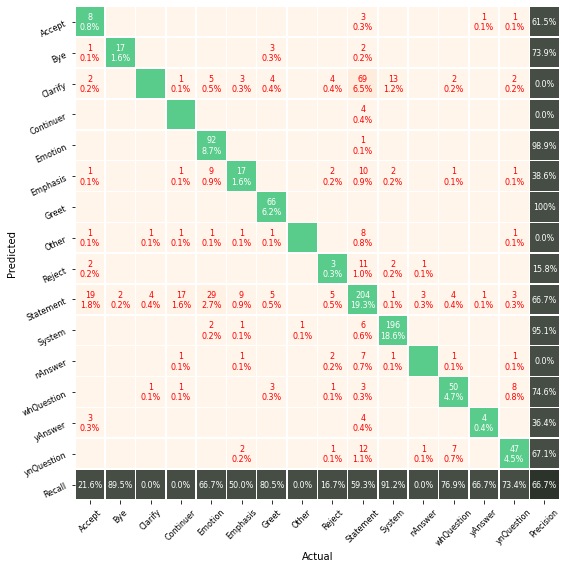

In [3]:
import seaborn
from matplotlib import pyplot

cm = dac_factory.print_confusion_matrix()

# Evenly distribute the training data labelled as "No" and "Yes".

In [4]:
X_train = training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = training_dataset[LABEL]
y_true = test_dataset[LABEL]

min_label_count = y_train.value_counts().min()
labelled_yes = training_dataset.loc[training_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = training_dataset.loc[training_dataset[LABEL] == 'No'].head(min_label_count)
evenly_distrubted_training_dataset = pandas.concat([labelled_yes, labelled_no])

# Shuffle the order, in order to properly train the model.
evenly_distrubted_training_dataset = evenly_distrubted_training_dataset.sample(frac=1)

X_train_evenly_dist = evenly_distrubted_training_dataset[FEATURES]
y_train_evenly_dist = evenly_distrubted_training_dataset[LABEL]

# Show the datasets value counts
dataset_dict = {}
dataset_dict['Training Dataset'] = len(training_dataset.loc[training_dataset[LABEL] == "Yes"]), len(training_dataset.loc[training_dataset[LABEL] == "No"]), len(training_dataset.loc[training_dataset[LABEL] == "Yes"])/len(training_dataset)
dataset_dict['Test Dataset'] = len(test_dataset.loc[test_dataset[LABEL] == "Yes"]), len(test_dataset.loc[test_dataset[LABEL] == "No"]), len(test_dataset.loc[test_dataset[LABEL] == "Yes"])/len(test_dataset)
df = DataFrame.from_dict(dataset_dict, orient='index', columns=['Label (Yes)', 'Label (No)', 'Ratio (Yes)'])

df

Label (Yes)  Label (No)  Ratio (Yes)
Training Dataset           92         506     0.153846
Test Dataset               39         111     0.260000

# Set up

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

is_author_categories = [
    False,  # 0 should come before 1 for numerical columns.
    True
]

# CountVectorizer - SVC

In [6]:
from sklearn.svm import SVC

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_count_vectorizer',
            CountVectorizer(stop_words='english'),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_count_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

clf_svc = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', probability=True))],
    verbose=False)

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CountVectorizer - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CountVectorizer - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - SVC

In [7]:
column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(stop_words='english', ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Stemming - SVC

In [8]:
from nltk.stem.snowball import SnowballStemmer

class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english', ignore_stopwords=True)
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

column_transformer = ColumnTransformer(
    transformers=[
        ('body_count_vectorizer', StemmedCountVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_count_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Stemming - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Stemming - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - SVC

In [9]:
from nlp import LemmaTokenizer

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', lowercase=True, ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=0.1, probability=True))
    ],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - SGDClassifier

In [10]:
from sklearn.linear_model import SGDClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SGDClassifier(random_state=13))
    ],
    verbose=False)

clf_sgd = full_pipeline

clf_sgd.fit(X_train, y_train)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_sgd.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - KNeighborsClassifier

In [11]:
from sklearn.neighbors import KNeighborsClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', KNeighborsClassifier())
    ],
    verbose=False)

clf_kneighbors = full_pipeline

clf_kneighbors.fit(X_train, y_train)
y_pred = clf_kneighbors.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - KNeighborsClassifier': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_kneighbors.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_kneighbors.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - KNeighborsClassifier (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression)

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', BaggingClassifier(base_estimator=LogisticRegression(C=500000, solver='lbfgs'), max_samples=0.5, max_features=0.5))
    ],
    verbose=False)

clf_ensemble = full_pipeline

clf_ensemble.fit(X_train, y_train)
y_pred = clf_ensemble.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression)': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_ensemble.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_ensemble.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression) (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - MultinomialNB

In [13]:
from sklearn.naive_bayes import MultinomialNB

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', MultinomialNB(fit_prior=True))],
    verbose=False)

clf_multinominal_nb = full_pipeline

clf_multinominal_nb.fit(X_train, y_train)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_multinominal_nb.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', RandomForestClassifier(max_features='auto', bootstrap=False, class_weight={'Yes': 0.2, 'No': 0.8}, random_state=20))],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'Random Forest': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_logistic_regression.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'Random Forest (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - LogisticRegression

In [15]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', LogisticRegression(C=500000, solver='liblinear', multi_class='ovr', intercept_scaling=1, dual=True, penalty='l2'))],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_logistic_regression.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - DecisionTree

In [16]:
from sklearn.tree import DecisionTreeClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', DecisionTreeClassifier(random_state=1, min_samples_split=0.25))],
    verbose=False)

clf_decision_tree = full_pipeline

clf_decision_tree.fit(X_train, y_train)
y_pred = clf_decision_tree.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - DecisionTree': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_decision_tree.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_decision_tree.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - DecisionTree (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# CodeComprehensionClassifierFactory

In [17]:
# from classifier import CodeComprehensionClassifierFactory

# clf_optimal = CodeComprehensionClassifierFactory.get_classifier(dac_labels)

# clf_optimal.fit(X_train, y_train)
# y_pred = clf_optimal.predict(X_test)

# report = metrics.classification_report(y_true, y_pred, digits=8)
# report_dict_list.append({'CodeComprehensionClassifierFactory': metrics.classification_report(y_true, y_pred, output_dict=True)})

# clf_optimal.fit(X_train_evenly_dist, y_train_evenly_dist)
# y_pred = clf_optimal.predict(X_test)

# report = metrics.classification_report(y_true, y_pred, digits=8)
# report_dict_list.append({'CodeComprehensionClassifierFactory (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Report Performance Before Grid Search (as it is time consuming)

In [18]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

df

Algorithms  no_precision  \
0                               CountVectorizer - SVC      0.798450   
1          CountVectorizer - SVC (Evenly Distributed)      0.864583   
2                                         TFIDF - SVC      0.768116   
3                    TFIDF - SVC (Evenly Distributed)      0.876404   
4                              TFIDF - Stemming - SVC      0.767606   
5         TFIDF - Stemming - SVC (Evenly Distributed)      0.890411   
6                         TFIDF - Lemmatization - SVC      0.845528   
7    TFIDF - Lemmatization - SVC (Evenly Distributed)      0.897959   
8               TFIDF - Lemmatization - SGDClassifier      0.902655   
9   TFIDF - Lemmatization - SGDClassifier (Evenly ...      0.908163   
10       TFIDF - Lemmatization - KNeighborsClassifier      0.776978   
11  TFIDF - Lemmatization - KNeighborsClassifier (...      0.908046   
12  TFIDF - Lemmatization - Ensemble Classifiers (...      0.785185   
13  TFIDF - Lemmatization - Ensemble Classifiers (...      0.900000   
14              TFIDF - Lemmatization - MultinomialNB      0.740000   
15  TFIDF - Lemmatization - MultinomialNB (Evenly ...      0.883721   
16                                      Random Forest      0.786765   
17                 Random Forest (Evenly Distributed)      0.905660   
18         TFIDF - Lemmatization - LogisticRegression      0.840000   
19  TFIDF - Lemmatization - LogisticRegression (Ev...      0.895833   
20               TFIDF - Lemmatization - DecisionTree      0.928571   
21  TFIDF - Lemmatization - DecisionTree (Evenly D...      0.927835   

    no_recall  no_f1_score  yes_precision  yes_recall  yes_f1_score  Accuracy  
0    0.927928     0.858333       0.619048    0.333333      0.433333  0.773333  
1    0.747748     0.801932       0.481481    0.666667      0.559140  0.726667  
2    0.954955     0.851406       0.583333    0.179487      0.274510  0.753333  
3    0.702703     0.780000       0.459016    0.717949      0.560000  0.706667  
4    0.981982     0.861660       0.750000    0.153846      0.255319  0.766667  
5    0.585586     0.706522       0.402597    0.794872      0.534483  0.640000  
6    0.936937     0.888889       0.740741    0.512821      0.606061  0.826667  
7    0.792793     0.842105       0.557692    0.743590      0.637363  0.780000  
8    0.918919     0.910714       0.756757    0.717949      0.736842  0.866667  
9    0.801802     0.851675       0.576923    0.769231      0.659341  0.793333  
10   0.972973     0.864000       0.727273    0.205128      0.320000  0.773333  
11   0.711712     0.797980       0.492063    0.794872      0.607843  0.733333  
12   0.954955     0.861789       0.666667    0.256410      0.370370  0.773333  
13   0.810811     0.853081       0.580000    0.743590      0.651685  0.793333  
14   1.000000     0.850575       0.000000    0.000000      0.000000  0.740000  
15   0.684685     0.771574       0.453125    0.743590      0.563107  0.700000  
16   0.963964     0.866397       0.714286    0.256410      0.377358  0.780000  
17   0.864865     0.884793       0.659091    0.743590      0.698795  0.833333  
18   0.945946     0.889831       0.760000    0.487179      0.593750  0.826667  
19   0.774775     0.830918       0.537037    0.743590      0.623656  0.766667  
20   0.819820     0.870813       0.615385    0.820513      0.703297  0.820000  
21   0.810811     0.865385       0.603774    0.820513      0.695652  0.813333

# Tuning the model with Grid Search

In [19]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        (
            'classifier', 
            DecisionTreeClassifier(random_state=2, min_samples_split=0.25)
        )
    ],
    verbose=False)

yes_f1_scorer = metrics.make_scorer(metrics.f1_score, pos_label="Yes")

grid_search_cv_params = [
    {
        'preprocessor__body_tfidf_vectorizer__tokenizer': [None, LemmaTokenizer()],
        'preprocessor__body_tfidf_vectorizer__stop_words': [None, 'english'],
        'preprocessor__body_tfidf_vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5)],
        'preprocessor__transformer_weights': [
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 1, 'is_author_transformer': 2},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 1, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 1, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 100},          
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 1, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 1, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 6},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 100},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 100, 'is_author_transformer': 1},
            {'body_tfidf_vectorizer': 100, 'dac_transformer': 100, 'is_author_transformer': 6},
        ],
        # # 'classifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        # # 'classifier__early_stopping': [True, False],
        # 'classifier__criterion': ['gini', 'entropy'],
        # 'classifier__splitter': ['best', 'random'],
        # 'classifier__max_depth': [None, 5, 10],
        # 'classifier__min_samples_split': [2, 0.1, 0.25, 1.0],
        # # 'classifier__min_samples_leaf': [1, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
        # # 'classifier__min_weight_fraction_leaf': [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
        # 'classifier__max_features': [None, 1, 'auto', 'sqrt', 'log2'],
        # # 'classifier__ccp_alpha': [0.0, 1.0, 100.0],
        # # 'classifier__class_weight': [None, 'balanced', {'Yes': 0.175, 'No': 0.825}],        
        # 'classifier__random_state': list(range(1, 5)),
    },
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_f1_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 1120 candidates, totalling 5600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 5600 out of 5600 | elapsed: 51.4min finished


{'preprocessor__body_tfidf_vectorizer__ngram_range': (1, 2),
 'preprocessor__body_tfidf_vectorizer__stop_words': 'english',
 'preprocessor__body_tfidf_vectorizer__tokenizer': <nlp.LemmaTokenizer.LemmaTokenizer at 0x12698b580>,
 'preprocessor__transformer_weights': {'body_tfidf_vectorizer': 4,
  'dac_transformer': 1,
  'is_author_transformer': 2}}

In [20]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.102725      0.013774         0.019900        0.008704   
1          0.105619      0.014290         0.018964        0.008249   
2          0.100549      0.017234         0.022688        0.009493   
3          0.097663      0.015012         0.019645        0.007915   
4          0.099603      0.016442         0.019785        0.007875   
5          0.100489      0.016844         0.019784        0.007497   
6          0.103413      0.018334         0.018599        0.008566   
7          0.101760      0.018474         0.020421        0.009915   
8          0.103197      0.020086         0.019222        0.007445   
9          0.103797      0.014881         0.019795        0.009208   
10         0.106147      0.017470         0.021906        0.009980   
11         0.100986      0.017681         0.020037        0.010009   
12         0.101428      0.015049         0.019779        0.009348   
13         0.103072      0.019123         0.020827        0.008431   
14         0.101610      0.016415         0.021445        0.010106   
15         0.102552      0.015039         0.019063        0.007267   
16         0.100727      0.017449         0.022203        0.015393   
17         0.100183      0.018426         0.019264        0.009853   
18         0.102186      0.018244         0.019848        0.008000   
19         0.101810      0.017763         0.020122        0.007404   
20         0.101537      0.015250         0.018785        0.008229   
21         0.100689      0.015324         0.019494        0.008165   
22         0.102731      0.017584         0.022199        0.009757   
23         0.106032      0.016807         0.019584        0.009230   
24         0.110961      0.023782         0.029608        0.020656   
25         0.104661      0.016294         0.025002        0.009637   
26         0.111377      0.021008         0.020232        0.010596   
27         0.110499      0.018844         0.019819        0.009877   
28         6.780137      1.546713         0.870695        1.512728   
29         5.449270      2.814297         0.846593        1.474227   
30         3.395256      1.494977         0.848229        1.470575   
31         3.471028      1.511140         0.896089        1.532395   
32         3.584074      1.572606         0.958219        1.602852   
33         3.613308      1.607774         0.844109        1.481327   
34         3.542453      1.542739         0.930586        1.651189   
35         3.612276      1.617807         0.859961        1.518447   
36         3.512993      1.538221         0.872945        1.517897   
37         3.557166      1.559321         0.888263        1.561079   
38         3.459334      1.534823         0.840686        1.480518   
39         3.452463      1.519987         0.877761        1.535611   
40         3.448667      1.521635         0.872248        1.534926   
41         3.469022      1.514597         0.828824        1.454340   
42         3.364588      1.479542         0.878695        1.550576   
43         3.447843      1.531506         0.854947        1.513558   
44         3.485321      1.540941         0.881644        1.549888   
45         3.612103      1.575782         0.900944        1.595363   
46         3.430700      1.521392         0.861793        1.511607   
47         3.478244      1.541402         0.844981        1.495925   
48         3.417342      1.515804         0.843585        1.484401   
49         3.375808      1.482396         0.888251        1.571990   
50         3.457154      1.521123         0.877986        1.546719   
51         3.422166      1.520801         0.859776        1.504763   
52         3.403136      1.500371         0.836457        1.473430   
53         3.383138      1.495199         0.864642        1.515817   
54         3.499202      1.539535         0.896174        1.571877   
55         3.487191      1.539963         0.858228        1.509791   
56         0.099

In [21]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'GridSearch': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Performance Result Comparison

In [22]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

df

Algorithms  no_precision  \
0                               CountVectorizer - SVC      0.798450   
1          CountVectorizer - SVC (Evenly Distributed)      0.864583   
2                                         TFIDF - SVC      0.768116   
3                    TFIDF - SVC (Evenly Distributed)      0.876404   
4                              TFIDF - Stemming - SVC      0.767606   
5         TFIDF - Stemming - SVC (Evenly Distributed)      0.890411   
6                         TFIDF - Lemmatization - SVC      0.845528   
7    TFIDF - Lemmatization - SVC (Evenly Distributed)      0.897959   
8               TFIDF - Lemmatization - SGDClassifier      0.902655   
9   TFIDF - Lemmatization - SGDClassifier (Evenly ...      0.908163   
10       TFIDF - Lemmatization - KNeighborsClassifier      0.776978   
11  TFIDF - Lemmatization - KNeighborsClassifier (...      0.908046   
12  TFIDF - Lemmatization - Ensemble Classifiers (...      0.785185   
13  TFIDF - Lemmatization - Ensemble Classifiers (...      0.900000   
14              TFIDF - Lemmatization - MultinomialNB      0.740000   
15  TFIDF - Lemmatization - MultinomialNB (Evenly ...      0.883721   
16                                      Random Forest      0.786765   
17                 Random Forest (Evenly Distributed)      0.905660   
18         TFIDF - Lemmatization - LogisticRegression      0.840000   
19  TFIDF - Lemmatization - LogisticRegression (Ev...      0.895833   
20               TFIDF - Lemmatization - DecisionTree      0.928571   
21  TFIDF - Lemmatization - DecisionTree (Evenly D...      0.927835   
22                                         GridSearch      0.928571   

    no_recall  no_f1_score  yes_precision  yes_recall  yes_f1_score  Accuracy  
0    0.927928     0.858333       0.619048    0.333333      0.433333  0.773333  
1    0.747748     0.801932       0.481481    0.666667      0.559140  0.726667  
2    0.954955     0.851406       0.583333    0.179487      0.274510  0.753333  
3    0.702703     0.780000       0.459016    0.717949      0.560000  0.706667  
4    0.981982     0.861660       0.750000    0.153846      0.255319  0.766667  
5    0.585586     0.706522       0.402597    0.794872      0.534483  0.640000  
6    0.936937     0.888889       0.740741    0.512821      0.606061  0.826667  
7    0.792793     0.842105       0.557692    0.743590      0.637363  0.780000  
8    0.918919     0.910714       0.756757    0.717949      0.736842  0.866667  
9    0.801802     0.851675       0.576923    0.769231      0.659341  0.793333  
10   0.972973     0.864000       0.727273    0.205128      0.320000  0.773333  
11   0.711712     0.797980       0.492063    0.794872      0.607843  0.733333  
12   0.954955     0.861789       0.666667    0.256410      0.370370  0.773333  
13   0.810811     0.853081       0.580000    0.743590      0.651685  0.793333  
14   1.000000     0.850575       0.000000    0.000000      0.000000  0.740000  
15   0.684685     0.771574       0.453125    0.743590      0.563107  0.700000  
16   0.963964     0.866397       0.714286    0.256410      0.377358  0.780000  
17   0.864865     0.884793       0.659091    0.743590      0.698795  0.833333  
18   0.945946     0.889831       0.760000    0.487179      0.593750  0.826667  
19   0.774775     0.830918       0.537037    0.743590      0.623656  0.766667  
20   0.819820     0.870813       0.615385    0.820513      0.703297  0.820000  
21   0.810811     0.865385       0.603774    0.820513      0.695652  0.813333  
22   0.819820     0.870813       0.615385    0.820513      0.703297  0.820000

# GridSearch with Evenly Distributed Dataset

In [23]:
clf_grid_search_cv.fit(X_train_evenly_dist, y_train_evenly_dist)
clf_grid_search_cv.best_params_


Fitting 5 folds for each of 1120 candidates, totalling 5600 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 2178 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 4306 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 5192 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5600 out of 5600 | elapsed:  3.3min finished


{'preprocessor__body_tfidf_vectorizer__ngram_range': (1, 3),
 'preprocessor__body_tfidf_vectorizer__stop_words': 'english',
 'preprocessor__body_tfidf_vectorizer__tokenizer': <nlp.LemmaTokenizer.LemmaTokenizer at 0x12698b580>,
 'preprocessor__transformer_weights': {'body_tfidf_vectorizer': 4,
  'dac_transformer': 1,
  'is_author_transformer': 2}}

In [24]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.037797      0.004730         0.018000        0.003249   
1          0.044825      0.005413         0.024468        0.006665   
2          0.044399      0.005204         0.012965        0.004951   
3          0.034540      0.004004         0.014113        0.004461   
4          0.028285      0.002284         0.013811        0.003833   
5          0.031886      0.003807         0.014716        0.004318   
6          0.034334      0.004333         0.015590        0.003319   
7          0.032794      0.005834         0.015852        0.001803   
8          0.030358      0.003349         0.014432        0.002040   
9          0.036885      0.004984         0.014528        0.001233   
10         0.033064      0.004961         0.012028        0.002950   
11         0.033386      0.002906         0.014471        0.002055   
12         0.031272      0.006996         0.015731        0.005454   
13         0.031355      0.004056         0.014488        0.001488   
14         0.034490      0.004598         0.014188        0.003611   
15         0.034309      0.006723         0.015069        0.006990   
16         0.036676      0.003331         0.014743        0.004213   
17         0.032633      0.003375         0.013756        0.003163   
18         0.029534      0.004986         0.016122        0.005384   
19         0.034136      0.004844         0.013685        0.002719   
20         0.031235      0.001888         0.013742        0.002027   
21         0.030014      0.003327         0.016707        0.002249   
22         0.038718      0.009126         0.021859        0.010918   
23         0.050545      0.014559         0.029096        0.031326   
24         0.038065      0.008438         0.043332        0.030388   
25         0.076029      0.035381         0.019284        0.012273   
26         0.036034      0.012096         0.011446        0.001280   
27         0.031220      0.004401         0.013494        0.003870   
28         0.186355      0.015509         0.053105        0.010248   
29         0.177315      0.006791         0.053693        0.006871   
30         0.189109      0.015707         0.058587        0.011679   
31         0.185279      0.012370         0.050877        0.005719   
32         0.186643      0.003203         0.051217        0.007475   
33         0.187426      0.012729         0.052222        0.010105   
34         0.175075      0.015656         0.047813        0.013939   
35         0.143684      0.007324         0.040036        0.005225   
36         0.140409      0.005321         0.039461        0.004962   
37         0.138970      0.007612         0.038788        0.005398   
38         0.147744      0.007383         0.038128        0.005599   
39         0.141181      0.005091         0.040350        0.005532   
40         0.152978      0.017538         0.040271        0.005093   
41         0.149778      0.012666         0.038801        0.004924   
42         0.147727      0.003760         0.039149        0.005174   
43         0.146391      0.006022         0.040640        0.004666   
44         0.155887      0.007760         0.042653        0.007352   
45         0.152956      0.007594         0.042170        0.004296   
46         0.151504      0.006544         0.041685        0.004522   
47         0.156651      0.011323         0.044702        0.005100   
48         0.159597      0.005320         0.043825        0.006411   
49         0.155149      0.007668         0.041440        0.006155   
50         0.155209      0.007936         0.044536        0.005434   
51         0.157372      0.005974         0.042079        0.005072   
52         0.156326      0.003821         0.043517        0.006411   
53         0.157558      0.009053         0.045216        0.007779   
54         0.153885      0.004763         0.042306        0.005735   
55         0.155834      0.008879         0.043312        0.006322   
56         0.026

In [25]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'GridSearch (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Performance Result Comparison

In [26]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

df

Algorithms  no_precision  \
0                               CountVectorizer - SVC      0.798450   
1          CountVectorizer - SVC (Evenly Distributed)      0.864583   
2                                         TFIDF - SVC      0.768116   
3                    TFIDF - SVC (Evenly Distributed)      0.876404   
4                              TFIDF - Stemming - SVC      0.767606   
5         TFIDF - Stemming - SVC (Evenly Distributed)      0.890411   
6                         TFIDF - Lemmatization - SVC      0.845528   
7    TFIDF - Lemmatization - SVC (Evenly Distributed)      0.897959   
8               TFIDF - Lemmatization - SGDClassifier      0.902655   
9   TFIDF - Lemmatization - SGDClassifier (Evenly ...      0.908163   
10       TFIDF - Lemmatization - KNeighborsClassifier      0.776978   
11  TFIDF - Lemmatization - KNeighborsClassifier (...      0.908046   
12  TFIDF - Lemmatization - Ensemble Classifiers (...      0.785185   
13  TFIDF - Lemmatization - Ensemble Classifiers (...      0.900000   
14              TFIDF - Lemmatization - MultinomialNB      0.740000   
15  TFIDF - Lemmatization - MultinomialNB (Evenly ...      0.883721   
16                                      Random Forest      0.786765   
17                 Random Forest (Evenly Distributed)      0.905660   
18         TFIDF - Lemmatization - LogisticRegression      0.840000   
19  TFIDF - Lemmatization - LogisticRegression (Ev...      0.895833   
20               TFIDF - Lemmatization - DecisionTree      0.928571   
21  TFIDF - Lemmatization - DecisionTree (Evenly D...      0.927835   
22                                         GridSearch      0.928571   
23                    GridSearch (Evenly Distributed)      0.927835   

    no_recall  no_f1_score  yes_precision  yes_recall  yes_f1_score  Accuracy  
0    0.927928     0.858333       0.619048    0.333333      0.433333  0.773333  
1    0.747748     0.801932       0.481481    0.666667      0.559140  0.726667  
2    0.954955     0.851406       0.583333    0.179487      0.274510  0.753333  
3    0.702703     0.780000       0.459016    0.717949      0.560000  0.706667  
4    0.981982     0.861660       0.750000    0.153846      0.255319  0.766667  
5    0.585586     0.706522       0.402597    0.794872      0.534483  0.640000  
6    0.936937     0.888889       0.740741    0.512821      0.606061  0.826667  
7    0.792793     0.842105       0.557692    0.743590      0.637363  0.780000  
8    0.918919     0.910714       0.756757    0.717949      0.736842  0.866667  
9    0.801802     0.851675       0.576923    0.769231      0.659341  0.793333  
10   0.972973     0.864000       0.727273    0.205128      0.320000  0.773333  
11   0.711712     0.797980       0.492063    0.794872      0.607843  0.733333  
12   0.954955     0.861789       0.666667    0.256410      0.370370  0.773333  
13   0.810811     0.853081       0.580000    0.743590      0.651685  0.793333  
14   1.000000     0.850575       0.000000    0.000000      0.000000  0.740000  
15   0.684685     0.771574       0.453125    0.743590      0.563107  0.700000  
16   0.963964     0.866397       0.714286    0.256410      0.377358  0.780000  
17   0.864865     0.884793       0.659091    0.743590      0.698795  0.833333  
18   0.945946     0.889831       0.760000    0.487179      0.593750  0.826667  
19   0.774775     0.830918       0.537037    0.743590      0.623656  0.766667  
20   0.819820     0.870813       0.615385    0.820513      0.703297  0.820000  
21   0.810811     0.865385       0.603774    0.820513      0.695652  0.813333  
22   0.819820     0.870813       0.615385    0.820513      0.703297  0.820000  
23   0.810811     0.865385       0.603774    0.820513      0.695652  0.813333

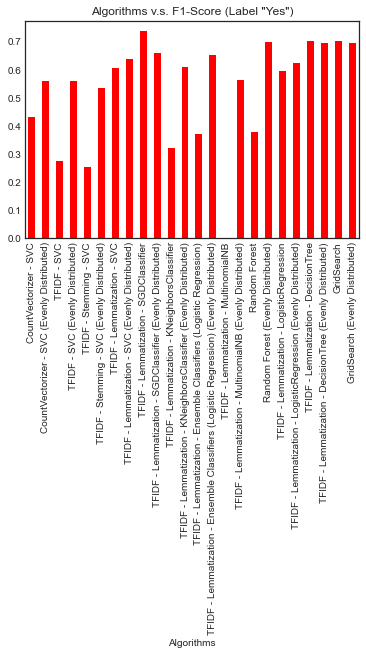

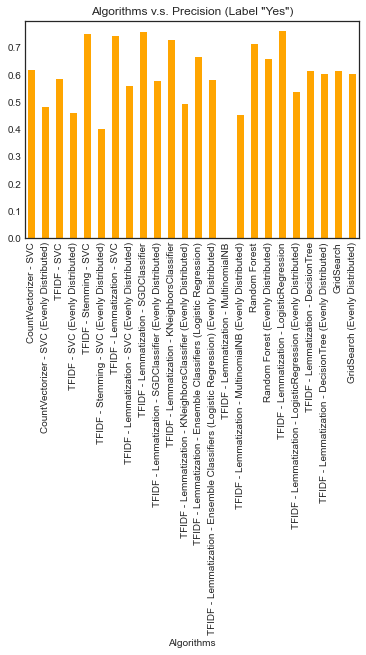

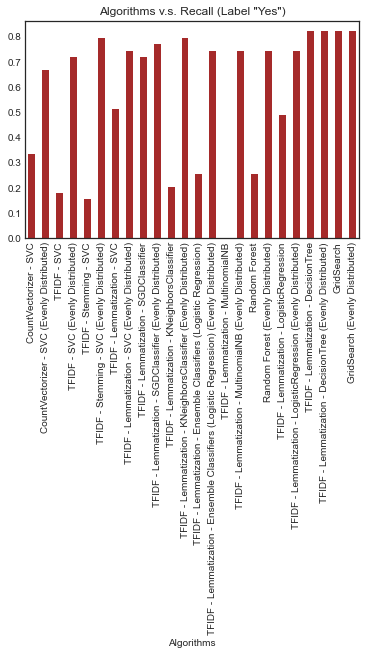

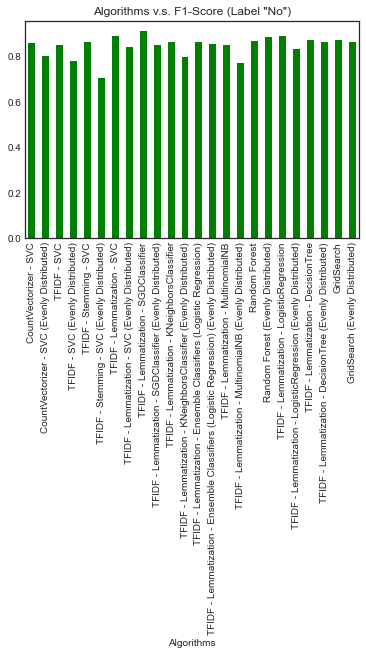

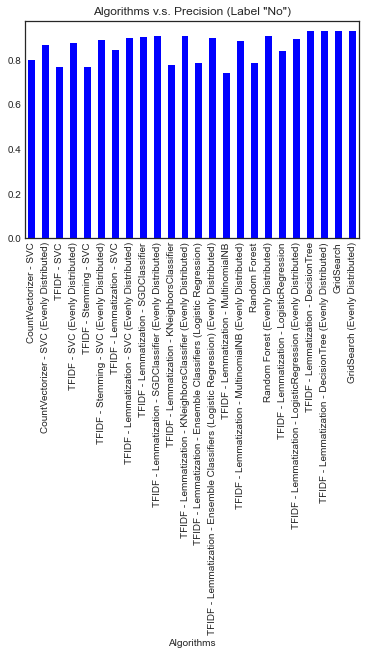

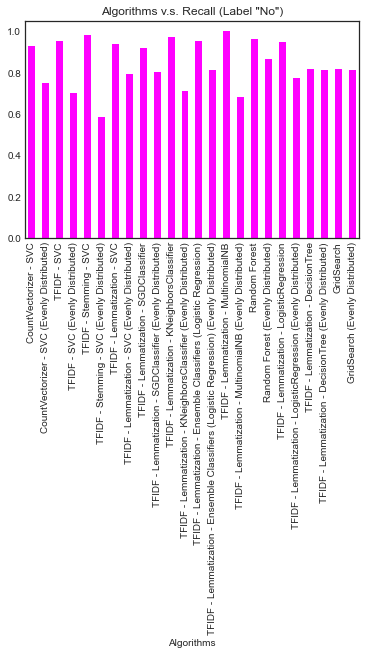

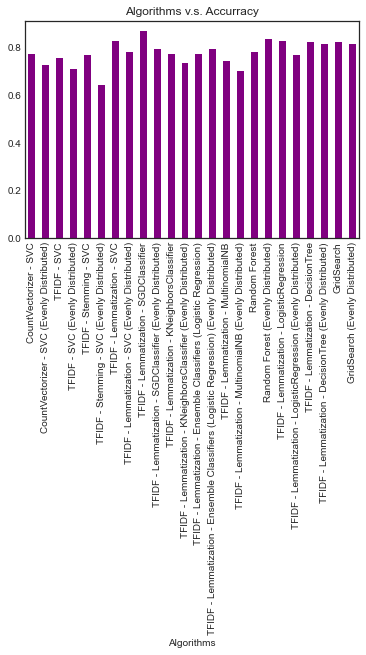

In [27]:
from matplotlib import pyplot

with pyplot.style.context('seaborn-white'):
    df.plot.bar(x='Algorithms', y='yes_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_precision', rot=90, title='Algorithms v.s. Precision (Label "Yes")', color='orange', legend=False)
    df.plot.bar(x='Algorithms', y='yes_recall', rot=90, title='Algorithms v.s. Recall (Label "Yes")', color='brown', legend=False)
    df.plot.bar(x='Algorithms', y='no_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "No")', color='green', legend=False)
    df.plot.bar(x='Algorithms', y='no_precision', rot=90, title='Algorithms v.s. Precision (Label "No")', color='blue', legend=False)
    df.plot.bar(x='Algorithms', y='no_recall', rot=90, title='Algorithms v.s. Recall (Label "No")', color='magenta', legend=False)
    df.plot.bar(x='Algorithms', y='Accuracy', rot=90, title='Algorithms v.s. Accurracy', color='purple', legend=False)

    # axes = df.plot.bar(rot=90, title="Algorithms Performance", subplots=True)

    pyplot.show(block=False)